In [ ]:
! pip install qiskit

     |████████████████████████████████| 6.4 MB 4.2 MB/s 
     |████████████████████████████████| 18.0 MB 50.8 MB/s 
     |████████████████████████████████| 238 kB 56.3 MB/s 
     |████████████████████████████████| 200 kB 65.7 MB/s 
     |████████████████████████████████| 53 kB 2.2 MB/s 
     |████████████████████████████████| 1.4 MB 66.2 MB/s 
     |████████████████████████████████| 49 kB 5.3 MB/s 
     |████████████████████████████████| 943 kB 54.5 MB/s 
     |████████████████████████████████| 49 kB 6.0 MB/s 
     |████████████████████████████████| 38.2 MB 1.2 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 3.6 MB 67.7 MB/s 
     |████████████████████████████████| 112 kB 58.4 MB/s 
  Created wheel for qiskit: filename=qiskit-0.34.0-py3-none-any.whl size=11764 sha256=9f1780476d5d028b08ccbe371f7d4884784473b48d20f51bef7764581c9fc058
  Stored in directory: /root/.cache/pip/wheels/be/f4/26/53ffcc0c3a1303116016eaf20c4f0c8dc125bc3b3c7af

In [ ]:
import qiskit
import PIL
import pandas as pd
import numpy as np
import os
import time
import operator
import tensorflow as tf
import matplotlib.pyplot as plt
import math

from qiskit import *
from qiskit.circuit import Reset
from qiskit.test.mock import FakeMontreal
from qiskit.compiler import transpile
from PIL import Image
from time import perf_counter
from tensorflow.keras import layers, models
from math import *

In [ ]:
def construct_data_frame(dir):
  nodule_types = ['NORMAL', 'BENIGN', 'MALIGNANT']
  data = []
  for nodule_num, nodule_type in enumerate(nodule_types):
    i = 1
    for image in os.listdir(os.path.join(dir, nodule_type)):
      image_file = Image.open('{}/{}/{}'.format(dir, nodule_type, image))
      data.append(['{}/{}/{}'.format(dir, nodule_type, image), nodule_num, nodule_type])
      if i == 20:
        break
      i += 1
  table = pd.DataFrame(data, columns = ['File', 'NoduleNum', 'NoduleTypes'])
  table = table.sample(frac=1).reset_index(drop=True)
  return table

In [ ]:
def quantum_filter(input_vals):
  qreg = QuantumRegister(5)
  creg = ClassicalRegister(1)
  circ = QuantumCircuit(qreg, creg)
  for qubit in qreg:
   circ.h(qubit)
  for i in range(4):
    circ.ry(pi*input_vals[i], i)
  circ.z(qreg[0])
  circ.h(qreg[3])
  circ.cx(qreg[2], qreg[3])
  circ.h(qreg[2])
  circ.h(qreg[3])
  circ.cx(qreg[1], qreg[2])
  circ.h(qreg[3])
  circ.h(qreg[1])
  circ.h(qreg[2])
  circ.cx(qreg[0], qreg[3])
  circ.h(qreg[2])
  circ.h(qreg[3])
  circ.cx(qreg[0], qreg[2])
  circ.h(qreg[3])
  circ.cx(qreg[0], qreg[1])
  circ.h(qreg[2])
  circ.h(qreg[1])
  circ.ccx(qreg[1], qreg[2], qreg[3])
  circ.h(qreg[2])
  circ.h(qreg[3])
  circ.ccx(qreg[0], qreg[1], qreg[2])
  circ.h(qreg[3])
  circ.h(qreg[2])
  circ.mcx([qreg[0], qreg[1], qreg[2]], qreg[3])
  circ.z(qreg[2])
  circ.h(qreg[3])
  circ.z(qreg[3])
  circ.h(qreg[3])
  circ.cx(qreg[2], qreg[3])
  circ.h(qreg[2])
  circ.h(qreg[3])
  circ.h(qreg[3])
  circ.cx(qreg[1], qreg[3])
  circ.h(qreg[1])
  circ.h(qreg[3])
  circ.h(qreg[3])
  circ.cx(qreg[0], qreg[3])
  circ.cx(qreg[0], qreg[2])
  circ.h(qreg[3])
  circ.cx(qreg[0], qreg[1])
  circ.h(qreg[2])
  circ.h(qreg[3])
  circ.x(qreg[0])
  circ.ccx(qreg[1], qreg[2], qreg[3])
  circ.h(qreg[1])
  circ.h(qreg[2])
  circ.h(qreg[3])
  circ.x(qreg[1])
  circ.x(qreg[2])
  circ.h(qreg[3])
  circ.x(qreg[3])
  circ.mcx([qreg[0], qreg[1], qreg[2], qreg[3]], qreg[4])
  circ.measure(qreg[4], creg)
  counts = execute(circ, Aer.get_backend('aer_simulator'), shots = 1000).result().get_counts(circ)
  key = max(counts.items(), key=operator.itemgetter(1))[0]
  return key == '1'

In [ ]:
def quantum_preprocess(train_nparrays):
  cnn_input = [] # input into cnn after quanvolution (preprocessing step)
  for curr_image in train_nparrays:
    dimensions = curr_image.shape
    num_rows_original = dimensions[0]
    num_cols_original = dimensions[1]
    modified_image_nparray = np.zeros((num_rows_original-1, num_cols_original-1))
    for row in range(num_rows_original-1):
      for col in range(num_cols_original-1):
        filter_input = [curr_image[row][col], 
                        curr_image[row][col+1],
                        curr_image[row+1][col], 
                        curr_image[row+1][col+1]]
        filter_output = quantum_filter(filter_input)
        if filter_output:
          modified_image_nparray[row][col] = 1 #check poss vals
    cnn_input.append(modified_image_nparray)
  return cnn_input

In [ ]:
# load data and preprocess
train_data = construct_data_frame('/content/drive/MyDrive/QC-Final-Project/Modified_Dataset/Train')
test_data = construct_data_frame('/content/drive/MyDrive/QC-Final-Project/Modified_Dataset/Test')

train_nparrays = []
train_nodule_types = []
for col, row in train_data.iterrows():
  image = Image.open(row['File'])
  image = image.resize((10, 10))
  image.save(row['File'])
  train_nparrays.append(np.asarray(Image.open(row['File'])))
  train_nodule_types.append(row['NoduleNum'])

test_nparrays = []
test_nodule_types = []
for col, row in test_data.iloc[0:20].iterrows():
  image = Image.open(row['File'])
  image = image.resize((10, 10))
  image.save(row['File'])
  test_nparrays.append(np.asarray(Image.open(row['File'])))
  test_nodule_types.append(test_data['NoduleNum'])

In [ ]:
cnn_input = np.array(quantum_preprocess(train_nparrays))
train_nodule_types = np.array(train_nodule_types)
test_nparrays = np.array(quantum_preprocess(test_nparrays))
test_nodule_types = np.array(test_nodule_types)

In [ ]:
# train
qcnn = models.Sequential()
qcnn.add(layers.Conv2D(32, (2, 2), activation = 'relu', input_shape=(9, 9, 1)))
qcnn.add(layers.MaxPooling2D(3, 3))
qcnn.add(layers.Conv2D(32, (1, 1), activation = 'relu', input_shape=(None, 2, 2, 10)))
qcnn.add(layers.Flatten())
qcnn.add(layers.Dense(3, activation='softmax'))
qcnn.compile(optimizer = 'adam',
             loss = "sparse_categorical_crossentropy",
             metrics = ["accuracy"])
history = qcnn.fit(cnn_input,
                   train_nodule_types,
                   validation_split = 0.2,
                   epochs = 10,
                   verbose = 2)

Epoch 1/10
2/2 - 1s - loss: 1.1290 - accuracy: 0.3125 - val_loss: 1.0477 - val_accuracy: 0.4167 - 565ms/epoch - 282ms/step
Epoch 2/10
2/2 - 0s - loss: 1.1155 - accuracy: 0.3125 - val_loss: 1.0742 - val_accuracy: 0.3333 - 30ms/epoch - 15ms/step
Epoch 3/10
2/2 - 0s - loss: 1.1058 - accuracy: 0.2500 - val_loss: 1.0998 - val_accuracy: 0.2500 - 24ms/epoch - 12ms/step
Epoch 4/10
2/2 - 0s - loss: 1.0974 - accuracy: 0.2917 - val_loss: 1.1250 - val_accuracy: 0.1667 - 23ms/epoch - 11ms/step
Epoch 5/10
2/2 - 0s - loss: 1.0914 - accuracy: 0.4167 - val_loss: 1.1514 - val_accuracy: 0.0000e+00 - 25ms/epoch - 13ms/step
Epoch 6/10
2/2 - 0s - loss: 1.0863 - accuracy: 0.4167 - val_loss: 1.1771 - val_accuracy: 0.0000e+00 - 23ms/epoch - 12ms/step
Epoch 7/10
2/2 - 0s - loss: 1.0815 - accuracy: 0.4167 - val_loss: 1.2017 - val_accuracy: 0.0000e+00 - 25ms/epoch - 13ms/step
Epoch 8/10
2/2 - 0s - loss: 1.0773 - accuracy: 0.4167 - val_loss: 1.2235 - val_accuracy: 0.0000e+00 - 38ms/epoch - 19ms/step
Epoch 9/10
2/2

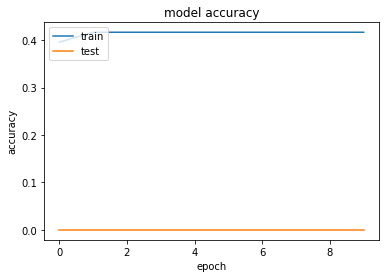

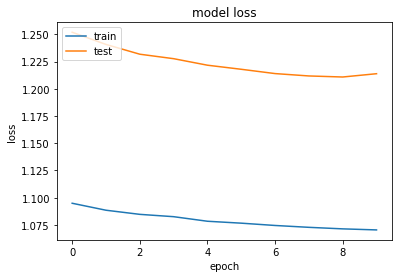

In [ ]:
# accuracy and loss plots
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()